Source: https://www.itl.nist.gov/div898/handbook/eda/section4/eda4231.htm

## Preparation

In [1]:
import os
os.chdir("..")
os.getcwd()

'C:\\Users\\An PC\\jupyter\\eda'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from utils import datasets
from utils import calculations
from utils.plotting import show_and_save_plot
from plots import (run_sequence_plot, histogram, 
                   lag_plot, probability_plot, 
                   scatter_plot, autocorrelation_plot)

---

# Random Walk
This example illustrates the univariate analysis of a set of numbers derived from a random walk.
1. Background and Data
2. Test Underlying Assumptions
3. Develop Better Model
4. Validate New Model

---

## Background and Data
### Generation 
A random walk can be generated from a set of uniform random numbers by the formula: $$R_i = \sum_{j=1}^i(U_j-0.5)$$ where $U$ is a set of uniform random numbers.

The motivation for studying a set of random walk data is to illustrate the effects of a known underlying autocorrelation structure (i.e., non-randomness) in the data. 
### Data source
https://www.itl.nist.gov/div898/handbook/datasets/RANDWALK.DAT

In [3]:
df = datasets.load_random_walk()
df.head()

,y
0,-0.399027
1,-0.645651
2,-0.625516
3,-0.262049
4,-0.407173


---

## Test Underlying Assumptions
### Goal
The goal of this analysis is threefold:
1. Determine if the univariate model: $Y_i=C+E_i$ is appropriate and valid.
2. Determine if the typical underlying assumptions for an "in control" measurement process are valid. These assumptions are:
    * random drawings;
    * from a fixed distribution;
    * with the distribution having a fixed location; and
    * the distribution having a fixed scale. 
3. Determine if the confidence interval $\bar{Y}\pm\frac{2s}{\sqrt{N}}$ is appropriate and valid where $s$ is the standard deviation of the original data.

### 4-Plot of Data

In [4]:
def four_plot(series, main_title="4-PLOT", show=True, save=False,
              run_kws=None, lag_kws=None, hist_kws=None, prob_kws=None):

    fig, axes = plt.subplots(nrows=2, ncols=2,
                             gridspec_kw={
                                 "left": 0.1, "right": 0.98,
                                 "top": 0.9, "bottom": 0.1,
                                 "wspace": 0.3, "hspace": 0.3,
                                 },
                             figsize=(7, 8))
    rsp, lag = axes[0]
    hist, prob = axes[1]
    
    # Run Sequence Plot
    run_kws = run_kws if run_kws is not None else {}
    clearance = (max(series)-min(series)) * 1/10
    y_lim = (min(series)-clearance, max(series)+clearance)
    run_sequence_plot(series, y_lim=y_lim, ax=rsp, show=False, **run_kws)

    # Lag Plot
    lag_kws = lag_kws if lag_kws is not None else {}
    lag_plot(series, ax=lag, show=False, **lag_kws)
    
    # Histogram
    hist_kws = hist_kws if hist_kws is not None else {}
    histogram(series, ax=hist, show=False, **hist_kws)

    # Probability Plot
    prob_kws = prob_kws if prob_kws is not None else {}
    probability_plot(series, ax=prob, show=False, **prob_kws)
    
    fig.suptitle(main_title)
    
    show_and_save_plot(show=show, save=save, filename="4-plot.png")

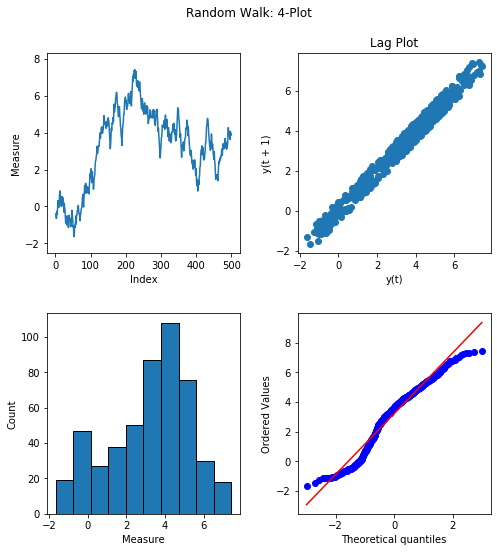

In [5]:
four_plot(df["y"], main_title="Random Walk: 4-Plot")

### Interpretation
The assumptions are addressed by the graphics shown above:
1. The run sequence plot (upper left) indicates significant shifts in location over time.
2. The lag plot (upper right) indicates significant non-randomness in the data.
3. When the assumptions of randomness and constant location and scale are not satisfied, the distributional assumptions are not meaningful. Therefore we do not attempt to make any interpretation of the histogram (lower left) or the normal probability plot (lower right).

From the above plots, we conclude that the underlying assumptions are seriously violated. Therefore the $Y_i = C + E_i$ model is not valid.

When the randomness assumption is seriously violated, a time series model may be appropriate. The lag plot often suggests a reasonable model. For example, in this case the strongly linear appearance of the lag plot suggests a model fitting $Y_i$ versus $Y_{i-1}$ might be appropriate. When the data are non-random, it is helpful to supplement the lag plot with an autocorrelation plot and a spectral plot. Although in this case the lag plot is enough to suggest an appropriate model, we provide the autocorrelation and spectral plots for comparison.

### Autocorrelation Plot
When the lag plot indicates significant non-randomness, it can be helpful to follow up with a an autocorrelation plot.

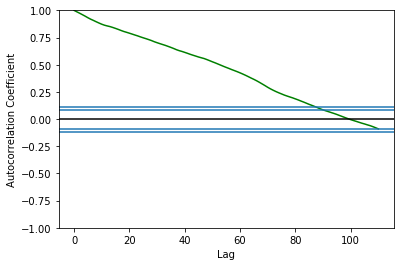

lag = 0, autocorrelation coefficient = 1.000
lag = 1, autocorrelation coefficient = 0.987
lag = 2, autocorrelation coefficient = 0.974
lag = 3, autocorrelation coefficient = 0.961
lag = 4, autocorrelation coefficient = 0.947


In [6]:
coefs, _, _ = autocorrelation_plot(df["y"], max_lag=110, c="green")
for lag, coef in enumerate(coefs[:5]):
    print("lag = {}, autocorrelation coefficient = {:.3f}".format(lag, coef))

This autocorrelation plot shows significant autocorrelation at lags 1 through 100 in a linearly decreasing fashion.

### Spectral Plot 
Another useful plot for non-random data is the spectral plot.

![](https://www.itl.nist.gov/div898/handbook/eda/section4/randwalk/gif/spectrum.gif)

This spectral plot shows a single dominant low frequency peak.

### Quantitative Output
Although the 4-plot above clearly shows the violation of the assumptions, we supplement the graphical output with some quantitative measures.

### Summary Statistics
As a first step in the analysis, common summary statistics are computed from the data.

In [7]:
df.describe()

,y
count,500.000000
mean,3.216682
std,2.078675
min,-1.638390
25%,1.747246
50%,3.612030
75%,4.681717
max,7.415205


We also computed the autocorrelation to be 0.987, which is evidence of a very strong autocorrelation.

In [8]:
def autocovariance(series, lag):
    N = len(series)
    mean = np.mean(series)
    Y = np.array(series)

    if lag == 0:
        return np.mean((Y-mean)**2)
    else:
        return np.sum((Y[:N-lag]-mean)*(Y[lag:]-mean)) / N


def autocorrelation_coefficient(series, lag):
    if lag == 0:
        return 1
    else:
        return autocovariance(series, lag) / autocovariance(series, 0)

In [9]:
autocorrelation_coefficient(df["y"], 1)

0.98686072665946

### Location
One way to quantify a change in location over time is to fit a straight line to the data using an index variable as the independent variable in the regression. For our data, we assume that data are in sequential run order and that the data were collected at equally spaced time intervals. In our regression, we use the index variable $X = 1, 2, ..., N$, where $N$ is the number of observations. If there is no significant drift in the location over time, the slope parameter should be zero. 

In [10]:
Y = df["y"]
X = df.index.values + 1
X = sm.add_constant(X)

In [11]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     86.02
Date:                Sun, 29 Sep 2019   Prob (F-statistic):           5.41e-19
Time:                        17:56:22   Log-Likelihood:                -1035.0
No. Observations:                 500   AIC:                             2074.
Df Residuals:                     498   BIC:                             2082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8335      0.172     10.653      0.0

In [12]:
SSR = np.sqrt(results.mse_resid)
print("Residual Standard Deviation =", SSR)
print("Residual Degrees of Freedom =", results.df_resid)

Residual Standard Deviation = 1.9214159828421162
Residual Degrees of Freedom = 498.0


The *t*-value of the slope parameter, 9.275, is larger than the critical value of $t_{0.975, 498}$ = 1.96. Thus, we conclude that the slope is different from zero at the 0.05 significance level. 

### Variation
One simple way to detect a change in variation is with a __Bartlett test__ after dividing the data set into several equal-sized intervals. However, the Bartlett test is not robust for non-normality. Since we know this data set is not approximated well by the normal distribution, we use the alternative __Levene test__. In particular, we use the Levene test based on the median rather the mean. The choice of the number of intervals is somewhat arbitrary, although values of four or eight are reasonable. We will divide our data into four intervals.

In [13]:
Y = df["y"]
G1, G2, G3, G4 = Y[:125], Y[125:250], Y[250:375], Y[375:]
for G in (Y, G1, G2, G3, G4):
    print(len(G))

500
125
125
125
125


__Null and alternative hypotheses__

>$H_0$:  $\sigma_1^2 = \sigma_2^2 = \sigma_3^2 = \sigma_4^2$
>
>$H_a$:  At least one $\sigma_i^2$ is not equal to the others.

In [14]:
w, p_value = stats.levene(G1, G2, G3, G4)
print("Test statistic =", w)
print("p-value =", p_value)

Test statistic = 10.4594013766543
p-value = 1.1064416046256912e-06


In this case, the Levene test indicates that the variances are significantly different in the four intervals since the p-value is less than 0.05. Therefore we conclude that the scale is not constant. 

### Randomness
Although the lag 1 autocorrelation coefficient above clearly shows the non-randomness, we show the output from a [runs test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35d.htm) as well.

*Hypotheses*

>$H_0$: the sequence was produced in a random manner
>
>$H_a$: the sequence was not produced in a random manner  

*Results*

>Test statistic: $Z = -20.3239$
>
>Significance level: $\alpha = 0.05$
>
>Critical value: $Z_{1-\frac{\alpha}{2}} = 1.96$ 
>
>Critical region: Reject $H_0$ if $|Z| > 1.96$

The runs test rejects the null hypothesis that the data were produced in a random manner at the 0.05 significance level. 

### Distributional Assumptions
Since the quantitative tests show that the assumptions of randomness and constant location and scale are not met, the distributional measures will not be meaningful. Therefore these quantitative tests are omitted.

---

## Develop a Better Model
### Lag Plot Suggests Better Model
Since the underlying assumptions did not hold, we need to develop a better model.

The lag plot showed a distinct linear pattern. Given the definition of the lag plot, $Y_i$ versus $Y_{i-1}$, a good candidate model is a model of the form
$$Y_i=A_0+A_1\times Y_{i−1}+E_i$$

### Fit Output
The results of a linear fit of this model generated the following results.

In [15]:
Y = df["y"].values
dependent = Y[1:]
independent = sm.add_constant(Y[:-1])

In [16]:
model = sm.OLS(dependent, independent)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 2.445e+04
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:56:22   Log-Likelihood:                -94.688
No. Observations:                 499   AIC:                             193.4
Df Residuals:                     497   BIC:                             201.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0502      0.024      2.075      0.0

In [17]:
print("Residual Standard Deviation =", np.sqrt(results.mse_resid))
print("Residual Degrees of Freedom =", results.df_resid)

Residual Standard Deviation = 0.2931194150879344
Residual Degrees of Freedom = 497.0


The slope parameter, $A_1$, has a *t*-value of 156.350 which is statistically significant. Also, the residual standard deviation is 0.2931. This can be compared to the standard deviation shown in the summary table, which is 2.078675. That is, the fit to the autoregressive model has reduced the variability by a factor of 7.

### Time Series Model
This model is an example of a time series model. More extensive discussion of time series is given in the [Process Monitoring](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm) chapter.

---

## Validate New Model
## Plot Predicted with Original Data
The first step in verifying the model is to plot the predicted values from the fit with the original data.

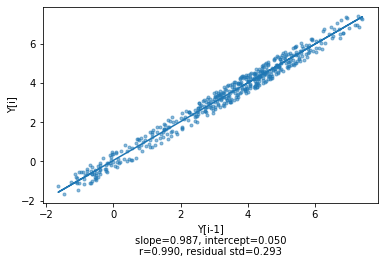

In [18]:
Y = df["y"].values[1:]
X = df["y"].values[:-1]
scatter_plot(X, Y, x_label="Y[i-1]", y_label="Y[i]", show_linear_fitting=True, marker=".",
             alpha=0.5)

This plot indicates a reasonably good fit.

### Test Underlying Assumptions on the Residuals
In addition to the plot of the predicted values, the residual standard deviation from the fit also indicates a significant improvement for the model. The next step is to validate the underlying assumptions for the error component, or residuals, from this model.

### 4-Plot of Residuals 

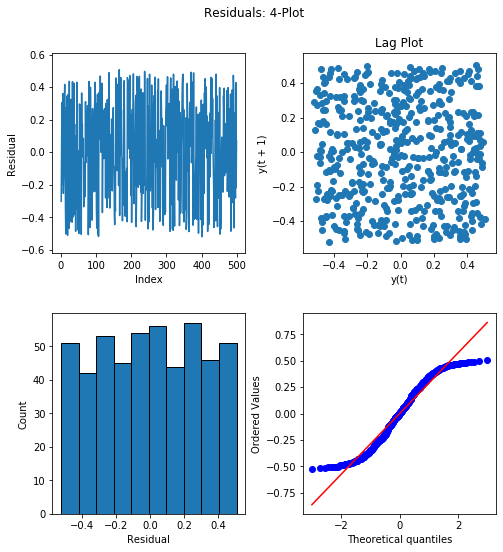

In [19]:
residuals = pd.Series(results.resid)

four_plot(residuals, main_title="Residuals: 4-Plot",
          run_kws={"x_label": "Index", "y_label": "Residual"},
          hist_kws={"x_label": "Residual"})

### Interpretation
The assumptions are addressed by the graphics shown above:
1. The run sequence plot (upper left) indicates no significant shifts in location or scale over time.
2. The lag plot (upper right) exhibits a random appearance.
3. The histogram shows a relatively flat appearance. This indicates that a uniform probability distribution may be an appropriate model for the error component (or residuals).
4. The normal probability plot clearly shows that the normal distribution is not an appropriate model for the error component. 

A uniform probability plot can be used to further test the suggestion that a uniform distribution might be a good model for the error component.

### Uniform Probability Plot of Residuals

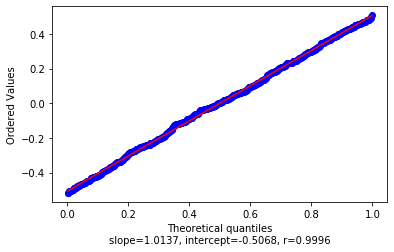

In [20]:
_, _ = probability_plot(residuals, distribution="uniform", show_fitting=True)

Since the uniform probability plot is nearly linear, this verifies that a uniform distribution is a good model for the error component.

### Conclusions
Since the residuals from our model satisfy the underlying assumptions, we conlude that $$Y_i = 0.0502 + 0.987\times Y_{i−1} + E_i$$ where the $E_i$ follow a uniform distribution is a good model for this data set.

We could simplify this model to $$Y_i = 1.0\times Y_{i−1} + E_i$$ 

This has the advantage of simplicity (the current point is simply the previous point plus a uniformly distributed error term).

### Using Scientific and Engineering Knowledge
In this case, the above model makes sense based on our definition of the random walk. That is, a random walk is the cumulative sum of uniformly distributed data points. It makes sense that modeling the current point as the previous point plus a uniformly distributed error term is about as good as we can do. Although this case is a bit artificial in that we knew how the data were constructed, it is common and desirable to use scientific and engineering knowledge of the process that generated the data in formulating and testing models for the data. Quite often, several competing models will produce nearly equivalent mathematical results. In this case, selecting the model that best approximates the scientific understanding of the process is a reasonable choice.

### Time Series Model
This model is an example of a time series model. More extensive discussion of time series is given in the [Process Monitoring](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm) chapter.

---